# Energy System Modelling - Tutorial III.2

**Settings**

In [1]:
import pypsa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline

In [2]:
solver = "glpk"

***
**(a) Build a network in PyPSA with the two buses North and South and attach the load at each bus and attach the wind and solar generators with availability according to $g^N_w(t) = c_w(1+A_w\sin \omega_w t)$ and $g^S_s(t) = c_s(1+A_s\sin \omega_s t)$ for a year (you have to call [`network.set_snapshots`](https://pypsa-readthedocs.readthedocs.io/en/readthedocs/api_reference.html?highlight=set_snapshots) to select a year) and with `p_nom_extendable=True`. As help you should have a look at the [PyPSA documentation](https://pypsa-readthedocs.readthedocs.io/en/readthedocs/index.html) and the [minimal lopf example](https://www.pypsa.org/examples/minimal_example_lopf.html), understand what the [components documentation](https://pypsa-readthedocs.readthedocs.io/en/readthedocs/components.html) of PyPSA gives you and that you can find the underlying objective function and constraints in the [LOPF documentation](https://pypsa-readthedocs.readthedocs.io/en/readthedocs/optimal_power_flow.html).**

> **Remarks:** For time reasons, you do not have to build the network from scratch. However, to get you acquainted with PyPSA we have omitted a few elements or some of the parameters of the network marked by three question marks `???`. Either, you have to add an element similar to the one in the box above or add a few parameters.

Initialize network

In [3]:
network = pypsa.Network()

Add North and South bus

In [4]:
network.add("Bus",
            "North",
            carrier="AC")

In [5]:
network.add("Bus",
            "South",
            carrier="AC")

Attach constant load

In [6]:
network.add("Load",
            "North Load",
            bus="North",
            p_set=20e3)

In [7]:
network.add("Load",
            "South Load",
            bus="South",
            p_set=30e3)

Attach renewable generators according to given parameters

In [8]:
network.set_snapshots(np.arange(0, 365*24))

In [9]:
Cfw = 0.3
Aw = 0.9
omegaw = 2*np.pi/(7*24)

Cfs = 0.12
As = 1.
omegas = 2*np.pi/24

GNwt = Cfw * (1+Aw*np.sin(omegaw*network.snapshots.to_series()))
GSst = Cfs * (1+As*np.sin(omegas*network.snapshots.to_series()))

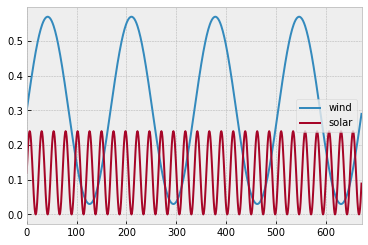

In [10]:
pd.concat([GNwt, GSst], keys=['wind', 'solar'], axis=1).loc[:4*7*24].plot()

In [11]:
network.add("Generator",
            "Wind",
            bus="North",
            p_nom_extendable=True,
            capital_cost=1.2e6,
            p_max_pu=GNwt)

In [12]:
network.add("Generator",
            "Solar",
            bus="South",
            p_nom_extendable=True,
            capital_cost=0.6e6,
            p_max_pu=GSst)

***
**(b) Attach extendable storage units at the North and the South! The storages have to be modelled as an `H2-bus` (a bus with `carrier='H2'`) linked to the `AC-bus` North with a `Link` where `p_nom_extendable=True` with the `capital_cost` of the power capacity and an also extendable `Store` with the `capital_cost` of the energy capacity, for instance. The losses can be set on the links as `efficiency`.**

In [13]:
for bus in ["North", "South"]:
    
    # H2 storage
    network.add("Bus",
                bus + " H2",
                carrier="H2")
    
    network.add("Store",
                bus + " H2 St.",
                bus=bus + " H2",
                e_nom_extendable=True,
                capital_cost=10e3)
    
    network.add("Link",
                bus + "->H2",
                bus0=bus, bus1=bus + " H2",
                p_nom_extendable=True,
                capital_cost=0.3e6,
                efficiency=0.75)
    
    network.add("Link",
                "H2->" + bus,
                bus0=bus + " H2", bus1=bus,
                p_nom_extendable=True,
                capital_cost=0.45e6,
                efficiency=0.405)
    
    # Battery storage
    network.add("Bus",
                bus + " Battery",
                carrier="Battery")
    
    network.add("Store",
                bus + " Battery St.",
                bus=bus + " Battery",
                e_nom_extendable=True,
                capital_cost=0.2e6)
    
    network.add("Link",
                bus + "->Battery",
                bus0=bus, bus1=bus + " Battery",
                p_nom_extendable=True,
                capital_cost=0.15e6,
                efficiency=0.9)
    
    network.add("Link",
                "Battery->" + bus,
                bus0=bus + " Battery", bus1=bus,
                p_nom_extendable=True,
                capital_cost=0.15e6,
                efficiency=0.9)

***
**(c) Run an investment optimization by calling the [`lopf`](https://pypsa-readthedocs.readthedocs.io/en/readthedocs/api_reference.html?highlight=set_snapshots) function.**

In [14]:
network.lopf(solver_name=solver)

INFO:pypsa.pf:Slack bus for sub-network 0 is North
INFO:pypsa.pf:Slack bus for sub-network 1 is South
INFO:pypsa.pf:Slack bus for sub-network 2 is North H2
INFO:pypsa.pf:Slack bus for sub-network 3 is North Battery
INFO:pypsa.pf:Slack bus for sub-network 4 is South H2
INFO:pypsa.pf:Slack bus for sub-network 5 is South Battery
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 360476623771.945
  Upper bound: 360476623771.945
  Number of objectives: 1
  Number of constraints: 29569
  Number of variables: 16143
  Number of nonzeros: 55073
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 3.898280382156372
# ----------------------------------------------------------
#   Solution Information
# -----

('ok', 'optimal')

***
**(d) How do your results `objective` and `{generators,stores,links}.p_nom_opt` compare with the results of III.1(d)?** 

Objective value

In [15]:
obj_v1 = network.objective / 1e9 # Mio. Euro
obj_v1

360.476623771945

Capacities for wind and solar.

In [16]:
res_cap_v1 = network.generators.p_nom_opt / 1e3 # GW
res_cap_v1 

Wind      87.381871
Solar    267.961955
Name: p_nom_opt, dtype: float64

Store and dispatch power capacity.

In [17]:
sto_cap_v1 = network.links.p_nom_opt / 1e3 # GW
sto_cap_v1 

North->H2         2.899018e+01
H2->North         2.984926e+01
North->Battery    1.357335e-02
Battery->North    7.330123e-02
South->H2        -3.795999e-14
H2->South        -5.069565e-14
South->Battery    3.431087e+01
Battery->South    3.333333e+01
Name: p_nom_opt, dtype: float64

Energy capacities.

In [18]:
sto_engy_v1 = network.stores.e_nom_opt / 1e6 # TWh
sto_engy_v1

North H2 St.         1.350790e+00
North Battery St.    1.832403e-04
South H2 St.        -5.576522e-16
South Battery St.    2.450389e-01
Name: e_nom_opt, dtype: float64

Plot the storage energy states over time

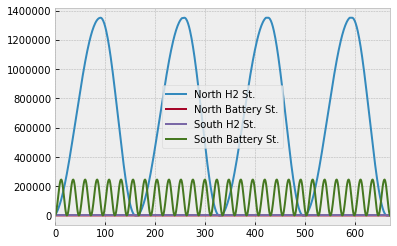

In [19]:
network.stores_t.e.plot()

***
**(e) Now we lift the restriction against transmission and allow North and South to bridge their 500 km
separation with a transmission line. How does the cost optimal technology mix change?**

Add extendable link between North and South: 

In [20]:
network.add("Link",
            "North<->South",
            bus0="North", bus1="South",
            p_min_pu=-1,
            p_nom_extendable=True,
            capital_cost=0.2e6)

Run LOPF:

In [21]:
network.lopf(solver_name=solver)

INFO:pypsa.pf:Slack bus for sub-network 0 is North
INFO:pypsa.pf:Slack bus for sub-network 1 is South
INFO:pypsa.pf:Slack bus for sub-network 2 is North H2
INFO:pypsa.pf:Slack bus for sub-network 3 is North Battery
INFO:pypsa.pf:Slack bus for sub-network 4 is South H2
INFO:pypsa.pf:Slack bus for sub-network 5 is South Battery
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 338496411380.838
  Upper bound: 338496411380.838
  Number of objectives: 1
  Number of constraints: 30913
  Number of variables: 16816
  Number of nonzeros: 59105
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 7.731746435165405
# ----------------------------------------------------------
#   Solution Information
# -----

('ok', 'optimal')

Get the results `objective` and `{generators,stores,links}.p_nom_opt` with real availability:

In [22]:
obj_v2 = network.objective / 1e9 # Mio. Euro
obj_v2

338.496411380838

In [23]:
# (a) Capacities for wind and solar.
res_cap_v2 = network.generators.p_nom_opt / 1e3  # GW
res_cap_v2

Wind     130.539736
Solar    174.567156
Name: p_nom_opt, dtype: float64

In [24]:
# (b) Store and dispatch power capacity.
sto_cap_v2 = network.links.p_nom_opt / 1e3 # GW
sto_cap_v2

North->H2         3.164925e+01
H2->North         4.696145e+01
North->Battery   -3.816990e-15
Battery->North    0.000000e+00
South->H2         2.138507e+01
H2->South         1.639586e+01
South->Battery    4.278347e+00
Battery->South    6.495718e+00
North<->South     2.390357e+01
Name: p_nom_opt, dtype: float64

In [25]:
# (c) Energy capacities
sto_engy_v2 = network.stores.e_nom_opt / 1e6 # TWh
sto_engy_v2

North H2 St.         1.467664e+00
North Battery St.   -2.061174e-17
South H2 St.         6.460265e-01
South Battery St.    2.576810e-02
Name: e_nom_opt, dtype: float64

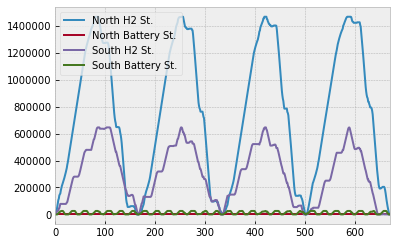

In [26]:
network.stores_t.e.plot()

***
**(e) Replace the approximated availability time-series of the wind and the solar generators with the ones from `availability.csv` computed from reanalysis weather data and re-run the LOPF. Compare the results! Explain the differences by looking at the cumulative variations relative to the mean of the availability time-series!**

Adapt the network to new availabiltiy data:

In [27]:
network.remove("Generator", "Wind")
network.remove("Generator", "Solar")

In [28]:
availability = pd.read_csv("data/availability.csv", index_col=0, parse_dates=True)
availability.head()

,solar,wind
name,,
2012-01-01 00:00:00,0.0,0.402412
2012-01-01 01:00:00,0.0,0.480648
2012-01-01 02:00:00,0.0,0.542354
2012-01-01 03:00:00,0.0,0.586046
2012-01-01 04:00:00,0.0,0.641201


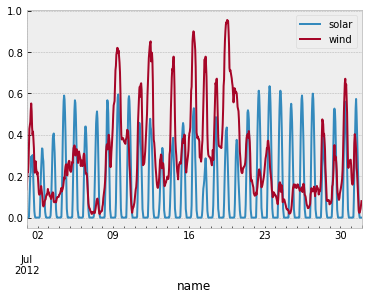

In [29]:
availability.loc["2012-7"].plot()

In [30]:
availability.loc["2012-7"].index

DatetimeIndex(['2012-07-01 00:00:00', '2012-07-01 01:00:00',
               '2012-07-01 02:00:00', '2012-07-01 03:00:00',
               '2012-07-01 04:00:00', '2012-07-01 05:00:00',
               '2012-07-01 06:00:00', '2012-07-01 07:00:00',
               '2012-07-01 08:00:00', '2012-07-01 09:00:00',
               ...
               '2012-07-31 14:00:00', '2012-07-31 15:00:00',
               '2012-07-31 16:00:00', '2012-07-31 17:00:00',
               '2012-07-31 18:00:00', '2012-07-31 19:00:00',
               '2012-07-31 20:00:00', '2012-07-31 21:00:00',
               '2012-07-31 22:00:00', '2012-07-31 23:00:00'],
              dtype='datetime64[ns]', name='name', length=744, freq=None)

In [31]:
network.set_snapshots(availability.loc["2012-7"].index)

In [32]:
network.add("Generator",
            "Wind",
            bus="North",
            p_nom_extendable=True,
            capital_cost=1.2e6,
            p_max_pu=availability["wind"])

In [33]:
network.add("Generator",
            "Solar",
            bus="South",
            p_nom_extendable=True,
            capital_cost=0.6e6,
            p_max_pu=availability["solar"])

Run LOPF:

In [34]:
network.lopf(solver_name="glpk")

INFO:pypsa.pf:Slack bus for sub-network 0 is North
INFO:pypsa.pf:Slack bus for sub-network 1 is South
INFO:pypsa.pf:Slack bus for sub-network 2 is North H2
INFO:pypsa.pf:Slack bus for sub-network 3 is North Battery
INFO:pypsa.pf:Slack bus for sub-network 4 is South H2
INFO:pypsa.pf:Slack bus for sub-network 5 is South Battery
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 525895790860.553
  Upper bound: 525895790860.553
  Number of objectives: 1
  Number of constraints: 34225
  Number of variables: 18616
  Number of nonzeros: 65191
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 8.02032470703125
# ----------------------------------------------------------
#   Solution Information
# ------

('ok', 'optimal')

Get the results `objective` and `{generators,stores,links}.p_nom_opt` with real availability:

In [35]:
obj_v3 = network.objective / 1e9 # Mio. Euro
obj_v3

525.895790860553

In [36]:
# (a) Capacities for wind and solar.
res_cap_v3 = network.generators.p_nom_opt / 1e3
res_cap_v3

Wind     365.287069
Solar     11.207320
Name: p_nom_opt, dtype: float64

In [37]:
# (b) Store and dispatch power capacity.
sto_cap_v3 = network.links.p_nom_opt / 1e3
sto_cap_v3

North->H2         72.666054
H2->North         69.478006
North->Battery     0.907102
Battery->North     3.344104
South->H2          0.038317
H2->South          0.069792
South->Battery     0.049307
Battery->South     0.133128
North<->South     30.000000
Name: p_nom_opt, dtype: float64

In [38]:
# (c) Energy capacities
sto_engy_v3 = network.stores.e_nom_opt / 1e6
sto_engy_v3

North H2 St.         1.956662
North Battery St.    0.006984
South H2 St.         0.001084
South Battery St.    0.000399
Name: e_nom_opt, dtype: float64

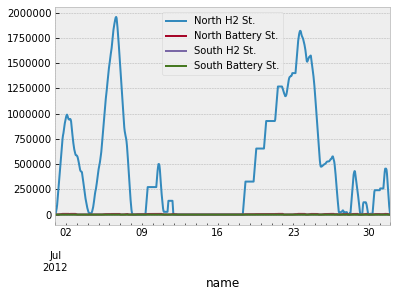

In [39]:
network.stores_t.e.plot()

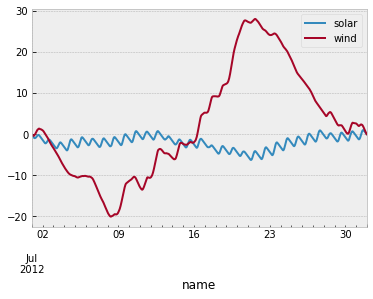

In [40]:
np.cumsum(availability.loc["2012-7"] - availability.loc["2012-7"].mean()).plot()

***
**(f) Compare all results for all three scenarios in terms of total system cost, renewable generation capacity, storage power capacity and storage energy capacity!**

> **Remark:** For example, you can use bar charts `plt.bar(...)` or `df.plot.bar()` to visualize the differences.

In [41]:
scens = ["without transmission",
         "with transmission",
         "with real data and transmission"]

attrs = ["storage power capacity",
         "storage energy capacity",
         "renewable capacity"]

In [42]:
sto_cap_v1.name = attrs[0] + " " + scens[0]
sto_cap_v2.name = attrs[0] + " " + scens[1]
sto_cap_v3.name = attrs[0] + " " + scens[2]

res_cap_v1.name = attrs[1] + " " + scens[0]
res_cap_v2.name = attrs[1] + " " + scens[1]
res_cap_v3.name = attrs[1] + " " + scens[2]

sto_engy_v1.name = attrs[2] + " " + scens[0]
sto_engy_v2.name = attrs[2] + " " + scens[1]
sto_engy_v3.name = attrs[2] + " " + scens[2]

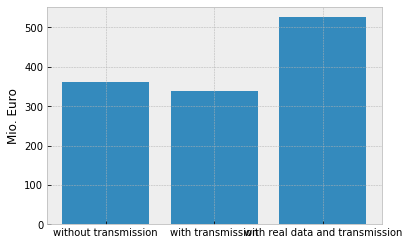

In [43]:
values = [obj_v1, obj_v2, obj_v3]
plt.bar(scens,values)
plt.ylabel('Mio. Euro')
plt.show()

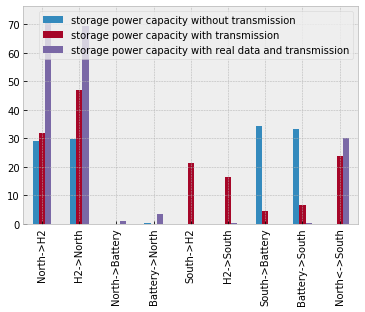

In [44]:
sto_caps = pd.concat([sto_cap_v1,sto_cap_v2,sto_cap_v3], axis=1, sort=False)
sto_caps.plot.bar()

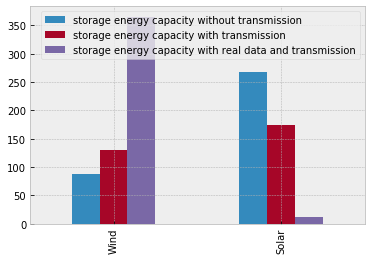

In [45]:
res_caps = pd.concat([res_cap_v1,res_cap_v2,res_cap_v3], axis=1, sort=False)
res_caps.plot.bar()

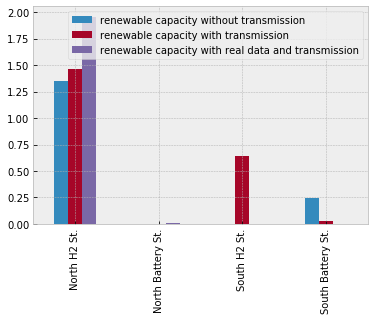

In [46]:
sto_engy = pd.concat([sto_engy_v1,sto_engy_v2,sto_engy_v3], axis=1, sort=False)
sto_engy.plot.bar()